In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train=(x_train)/255.0
x_test=(x_test)/255.0
x_train.shape,y_train.shape,x_test.shape,y_test.shape

170508288/170498071 [==============================] - 14s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
class_labels={
    0:'Airplane',
    1:'Automobile',
    2:'Bird',
    3:'Cat',
    4:'Deer',
    5:'Dog',
    6:'Frog',
    7:'Horse',
    8:'Ship',
    9:'Truck'
}

In [31]:
def show_images(images,labels,preds=False):
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    plt.style.use('fivethirtyeight')
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        img=images[idx]
        plt.imshow(img)
        if preds:
            plt.title(class_labels[np.argmax(labels[idx])])
        else:
            plt.title(class_labels[labels[idx].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
from tensorflow.keras.models import Sequential

In [6]:
augment_data=Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(.4),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(.1,.1),
])

In [27]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.cache()
train_data=train_data.shuffle(50000)
train_data=train_data.batch(128)
# train_data=train_data.map(lambda x,y:(augment_data(x),y))
train_data=train_data.prefetch(64)

test_data=tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_data=test_data.batch(32)
test_data=test_data.prefetch(16)

In [29]:
train_iterator=train_data.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

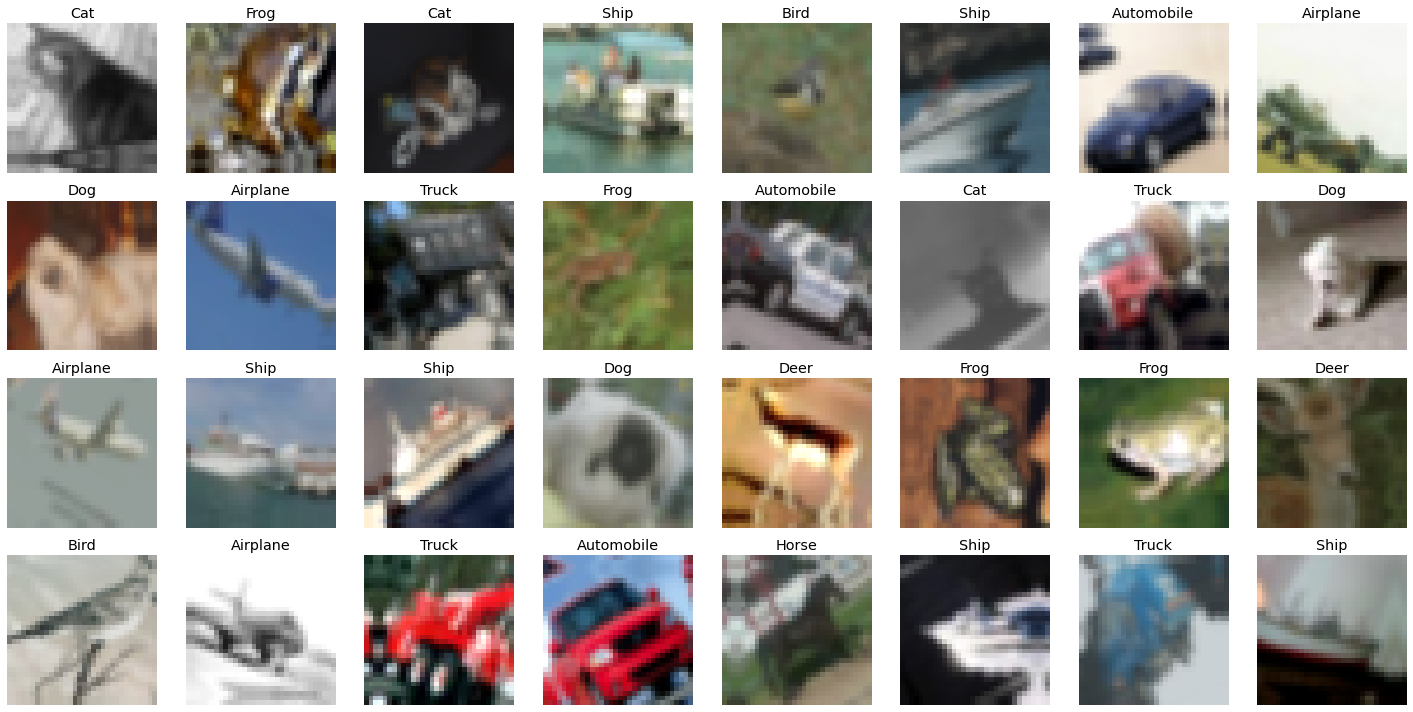

In [9]:
images,labels=train_iterator.next()
show_images(images[:32],labels[:32])

In [10]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,BatchNormalization,MaxPool2D,Activation,Add
from tensorflow.keras import Input,Model,initializers

In [11]:
def identity_block(inputs,filters):
    [filter1,filter2,filter3]=filters
    x_skip=inputs

    # layer 1
    x=Conv2D(filter1,(3,3),strides=(1,1),padding='same',kernel_initializer=initializers.GlorotUniform())(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    # layer 2
    x=Conv2D(filter2,(3,3),strides=(1,1),padding='same',kernel_initializer=initializers.GlorotUniform())(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    # layer 3
    x=Conv2D(filter3,(3,3),strides=(1,1),padding='same',kernel_initializer=initializers.GlorotUniform())(x)
    x=BatchNormalization()(x)

    x=Add()([x,x_skip])
    x=Activation('relu')(x)

    return x

In [12]:
noise=np.random.normal(size=(1,32,32,3))
identity_block(noise,[32,32,3]).shape

TensorShape([1, 32, 32, 3])

In [13]:
def convolution_block(inputs,filters):
    [filter1,filter2,filter3]=filters

    x_skip=inputs

    # layer 1
    x=Conv2D(filter1,(3,3),strides=(2,2),padding='same',kernel_initializer=initializers.GlorotUniform())(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    # layer 2
    x=Conv2D(filter3,(3,3),strides=(1,1),padding='same',kernel_initializer=initializers.GlorotUniform())(x)
    x=BatchNormalization()(x)
    
    x_skip=Conv2D(filter3,(1,1),strides=(2,2),padding='same',kernel_initializer=initializers.GlorotUniform())(x_skip)
    x_skip=BatchNormalization()(x_skip)
    
    x=Add()([x,x_skip])
    x=Activation('relu')(x)

    return x

In [14]:
noise=np.random.normal(size=(1,32,32,3))
convolution_block(noise,[32,32,3]).shape

TensorShape([1, 16, 16, 3])

In [15]:
def ResNet(input_shape=(32,32,3),num_classes=10):
    inputs=Input(shape=input_shape,name='input_layer')

    x=Conv2D(128,(3,3),1,padding='same')(inputs)
    
    x=convolution_block(x,[64,64,64])
    x=identity_block(x,[64,64,64])
    x=identity_block(x,[64,64,64])
    x=identity_block(x,[64,64,64])

    x=convolution_block(x,[64,64,128])
    x=identity_block(x,[64,64,128])
    x=identity_block(x,[64,64,128])
    x=identity_block(x,[64,64,128])

    x=convolution_block(x,[64,64,128])
    x=identity_block(x,[64,64,128])
    x=identity_block(x,[64,64,128])
    x=identity_block(x,[128,128,128])
    x=identity_block(x,[128,128,128])

    x=Conv2D(64,(3,3),padding='same',activation='relu')(x)

    x=Flatten()(x)
    outputs=Dense(num_classes,activation='softmax')(x)

    model=Model(inputs=inputs,outputs=outputs,name='ResNet')
    return model

In [16]:
model=ResNet()
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 128)  3584        ['input_layer[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   73792       ['conv2d_6[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_7[0][0]']               
 rmalization)                                                                                

In [17]:
from tensorflow.keras.utils import plot_model

In [50]:
# plot_model(model,to_file='model_plot.png')

In [19]:
model=tf.keras.models.load_model(os.path.join('models','cifar10_resnet.h5'))

In [32]:
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=.002),
#     metrics=['accuracy']
# )

In [45]:
# history=model.fit(train_data,epochs=10,validation_data=test_data,callbacks=[
#     tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     tf.keras.callbacks.ModelCheckpoint('temp/checkpoint',save_weights_only=True,monitor='val_accuracy',save_best_only=True)
# ])

Epoch 1/10
391/391 [==============================] - 29s 73ms/step - loss: 0.1187 - accuracy: 0.9585 - val_loss: 0.5390 - val_accuracy: 0.8573
Epoch 2/10
391/391 [==============================] - 29s 73ms/step - loss: 0.1201 - accuracy: 0.9583 - val_loss: 0.4283 - val_accuracy: 0.8889
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.1193 - accuracy: 0.9585 - val_loss: 0.4840 - val_accuracy: 0.8780
Epoch 4/10
391/391 [==============================] - 28s 71ms/step - loss: 0.1176 - accuracy: 0.9590 - val_loss: 0.4788 - val_accuracy: 0.8723
Epoch 5/10
391/391 [==============================] - 28s 71ms/step - loss: 0.1095 - accuracy: 0.9631 - val_loss: 0.4546 - val_accuracy: 0.8819
Epoch 6/10
391/391 [==============================] - 28s 72ms/step - loss: 0.2213 - accuracy: 0.9273 - val_loss: 0.4437 - val_accuracy: 0.8722
Epoch 7/10
391/391 [==============================] - 28s 72ms/step - loss: 0.1348 - accuracy: 0.9530 - val_loss: 0.3928 - val_accuracy:

In [46]:
# df=pd.DataFrame(history.history)
# df.to_csv('model_loss.csv',index=False)

<Figure size 1440x360 with 0 Axes>

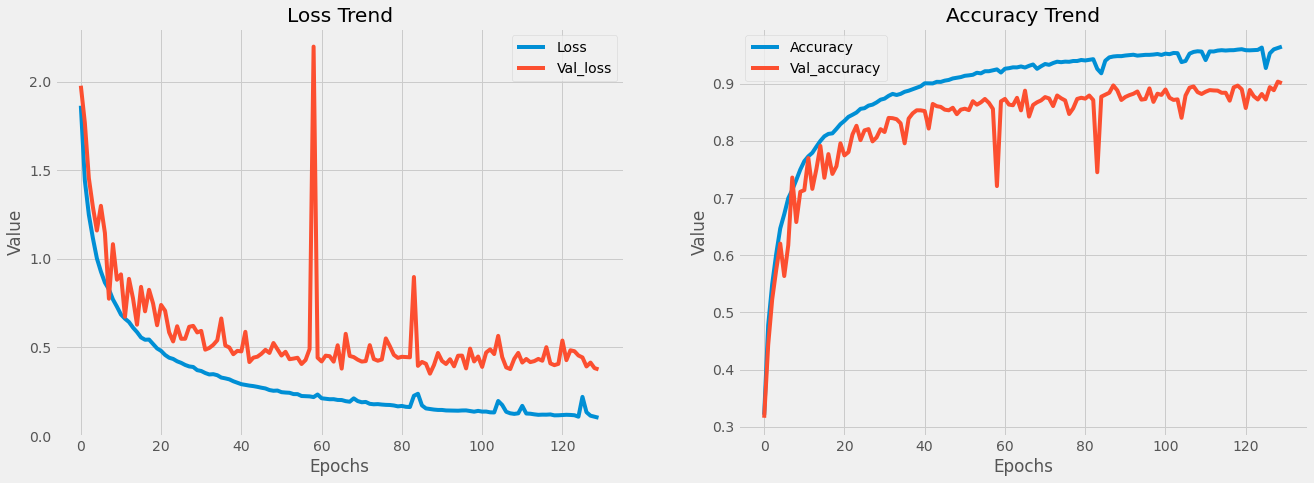

In [20]:
plt.style.use('fivethirtyeight')
df=pd.read_csv('model_loss.csv')
plt.figure(figsize=(20,5))
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
ax1.plot(df['loss'],label='Loss')
ax1.plot(df['val_loss'],label='Val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Value')
ax1.set_title('Loss Trend')
ax1.legend()

ax2.plot(df['accuracy'],label='Accuracy')
ax2.plot(df['val_accuracy'],label='Val_accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Accuracy Trend')
ax2.legend()

plt.show()

In [49]:
# tf.keras.models.save_model(model,os.path.join('models','cifar10_resnet.h5'))
# model.save('metadata')

In [21]:
model.load_weights('temp/checkpoint')

## Predictions on training dataset

4/4 [==============================] - 1s 180ms/step


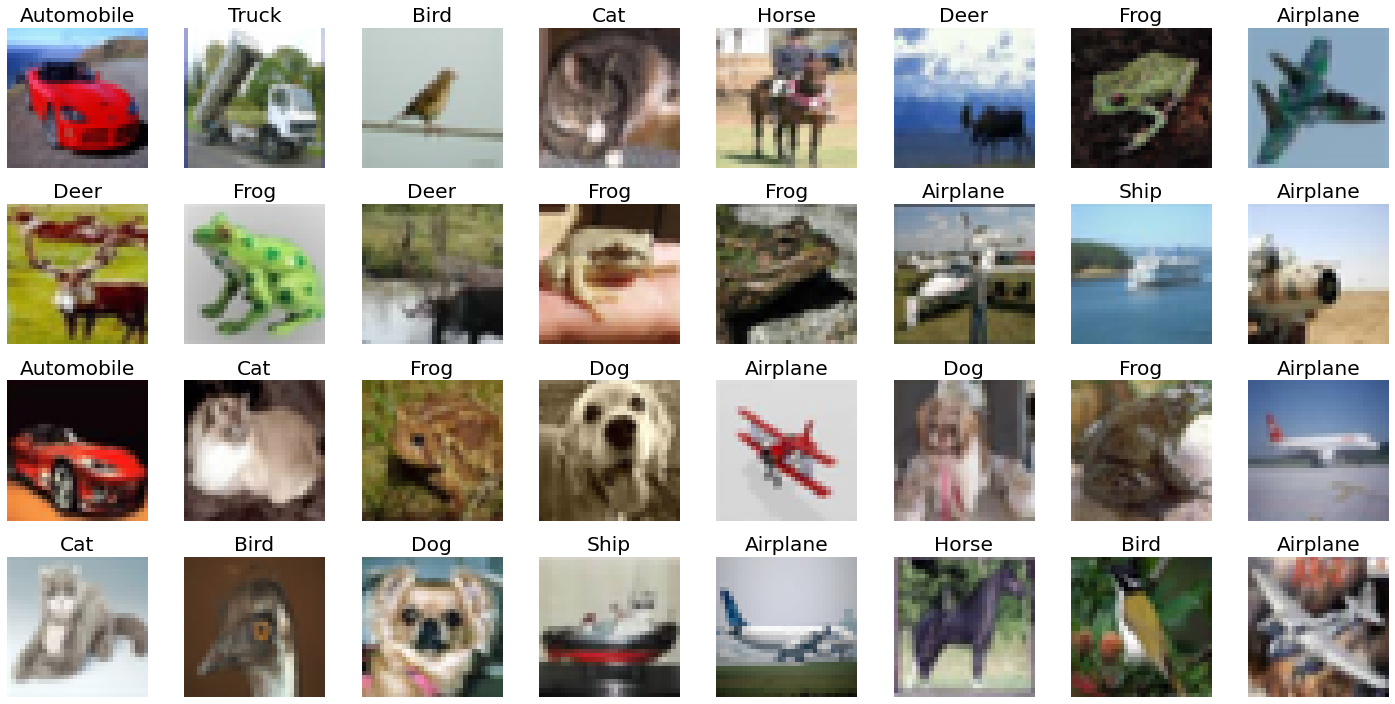

In [32]:
images,labels=train_iterator.next()
pred=model.predict(images)
show_images(images[:32],pred[:32],True)

## Predictions on testing dataset

In [34]:
loss,acc=model.evaluate(test_data)
print(f'Model loss: {loss:.4f}')
print(f'Model accuracy: {acc*100:.4f}%')

313/313 [==============================] - 59s 187ms/step - loss: 0.3836 - accuracy: 0.9035
Model loss: 0.3836
Model accuracy: 90.3500%


In [35]:
preds=model.predict(x_test,verbose=0)

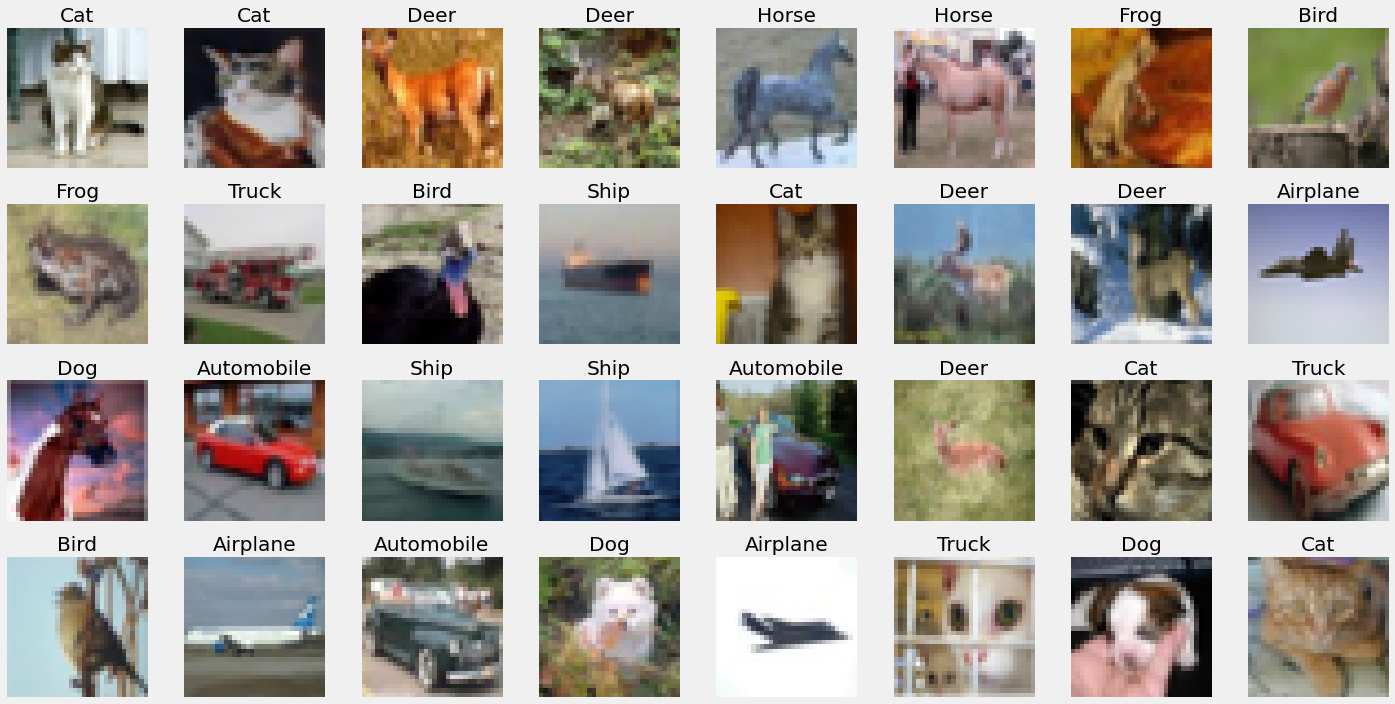

In [36]:
indexes=np.random.randint(0,9999,size=(32,))
images=np.expand_dims(x_test[indexes[0]],axis=0)
pred=np.expand_dims(preds[indexes[0]],axis=0)
for i in range(1,len(indexes)):
    images=np.concatenate([images,np.expand_dims(x_test[indexes[i]],axis=0)],axis=0)
    pred=np.concatenate([pred,np.expand_dims(preds[indexes[i]],axis=0)],axis=0)
show_images(images,pred,True)

## Predictions on images from internet

In [39]:
import cv2

In [40]:
def plot_prediction(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=img/255.0
    small_img=cv2.resize(img,(32,32))
    model_img=np.expand_dims(cv2.resize(small_img,(32,32)),axis=0)
    pred=model.predict(model_img,verbose=0)[0]
    
    df=pd.DataFrame(pred).T
    df=df.sort_values(0,axis=1,ascending=False).T
    df=df[:7].T
    classes=[]
    probs=[]
    for idx in df.columns.values:
        classes.append(class_labels[idx])
        probs.append(df.loc[0,idx])
    plt.style.use('seaborn-poster')
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(14,4))
    ax1.imshow(img)
    ax1.axis('off')

    ax2.barh(classes,probs,color='orange')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Classes')
    plt.tight_layout()
    plt.show()

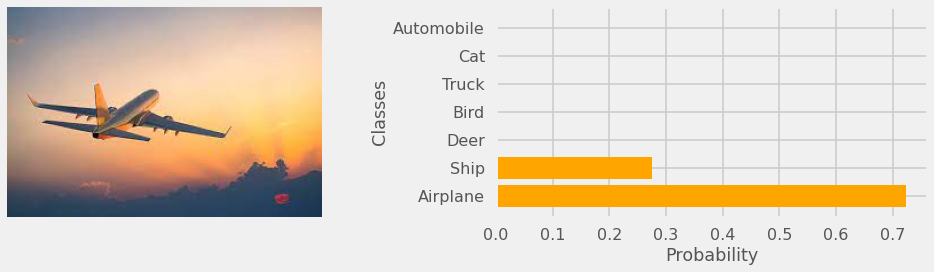

In [42]:
plot_prediction('..\web images\\airplane.jpg')

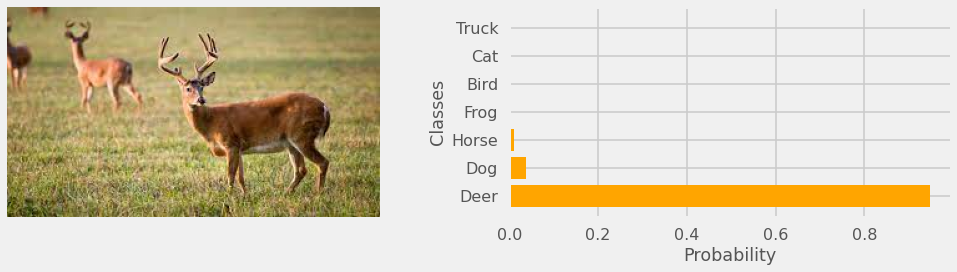

In [45]:
plot_prediction('..\web images\deer.jpg')

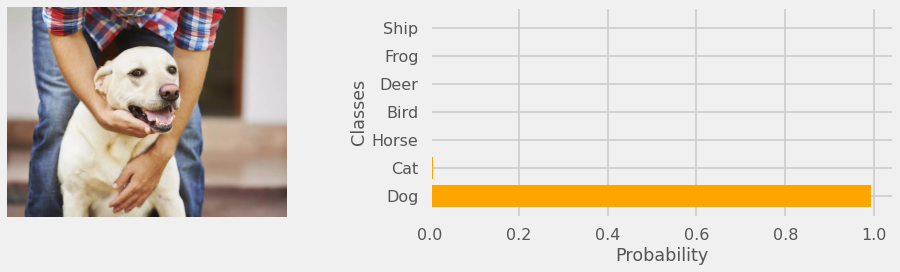

In [46]:
plot_prediction('..\web images\dog.jpg')

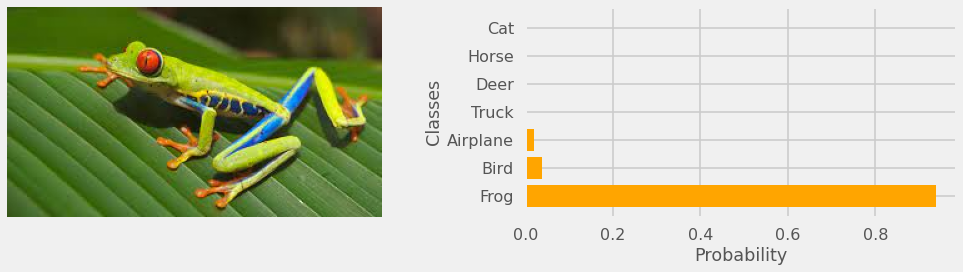

In [47]:
plot_prediction('..\web images\\frog.jpg')

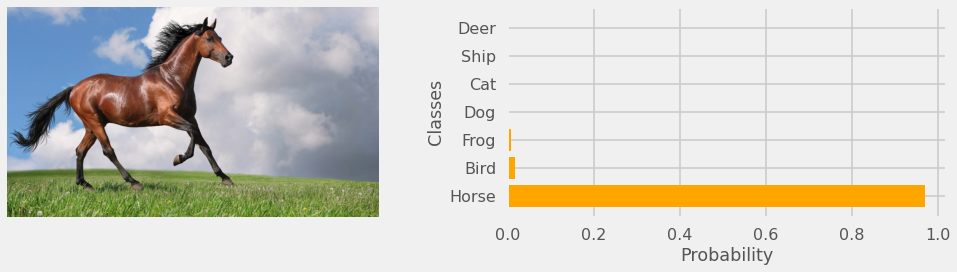

In [48]:
plot_prediction('..\web images\horse.jpg')

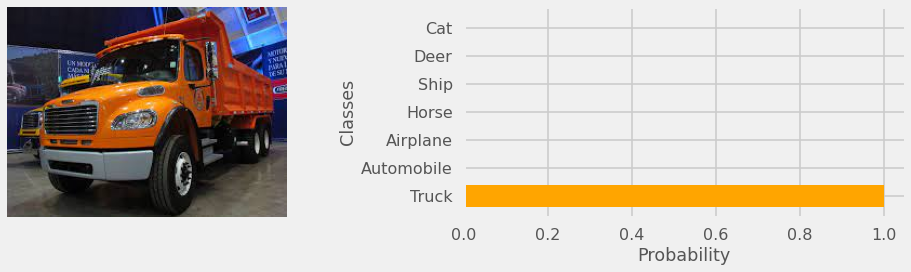

In [49]:
plot_prediction('..\web images\\truck.jpg')